In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import os

import json
import pandas as pd

from sqlalchemy.types import TIMESTAMP as typeTIMESTAMP

from dotenv import load_dotenv

load_dotenv(verbose=True)

import math
import logging
logger = logging.getLogger(__name__)

import dateutil

In [2]:
print (os.getcwd())

/Users/shivangi/Documents/Dissertation/BERT/power_monitor_analysis


In [3]:
from sqlalchemy import create_engine
REMOTE_HOST=os.getenv('REMOTE_HOST')
REMOTE_DB_PASS=os.getenv('REMOTE_DB_PASS')
REMOTE_USER=os.getenv('REMOTE_USER')
DB_NAME=os.getenv('DB_NAME')

engine = create_engine(f'postgresql+psycopg2://{REMOTE_USER}:{REMOTE_DB_PASS}@{REMOTE_HOST}/{DB_NAME}', server_side_cursors=True)

In [22]:
# table_name='events'

# last_hours = 24
# df = pd.read_sql_query(f"""
# SELECT
#        to_timestamp(event_data::json -> 'new_state' ->> 'last_changed','YYYY-MM-DD"T"HH24:MI:SS.US') as last_changed,
#        event_data::json -> 'new_state' -> 'entity_id' as entity_id,
#        event_data::json -> 'new_state' -> 'attributes' -> 'node_id' as node_id,
#        event_data::json -> 'new_state' -> 'attributes' -> 'power_consumption' as power_consumption,
#        event_data::json -> 'new_state' -> 'attributes' -> 'unit_of_measurement' as unit
# FROM  events
# WHERE event_type like 'state_changed'
# AND event_data::json ->> 'entity_id' = 'sensor.aeon_labs_zw096_smart_switch_6_power_2'
# -- ORDER BY last_changed DESC limit 3600 * {last_hours}
# ;
# """, con=engine)

In [23]:
# df['last_changed'] = pd.to_datetime(df['last_changed'], errors='coerce')
# df.dropna(subset=['last_changed'], inplace=True)
# df.set_index('last_changed', inplace=True)

In [25]:
# df

,entity_id,node_id,power_consumption,unit
last_changed,,,,
2020-05-30 14:32:48.779499+00:00,sensor.aeon_labs_zw096_smart_switch_6_power_2,5.0,16.826,W
2020-05-30 14:32:51.795031+00:00,sensor.aeon_labs_zw096_smart_switch_6_power_2,5.0,16.551,W
2020-05-30 14:32:54.798765+00:00,sensor.aeon_labs_zw096_smart_switch_6_power_2,5.0,16.770,W
2020-05-30 14:32:57.793024+00:00,sensor.aeon_labs_zw096_smart_switch_6_power_2,5.0,16.888,W
2020-05-30 14:33:00.791574+00:00,sensor.aeon_labs_zw096_smart_switch_6_power_2,5.0,16.677,W
...,...,...,...,...
2020-05-30 14:32:33.790128+00:00,sensor.aeon_labs_zw096_smart_switch_6_power_2,5.0,16.784,W
2020-05-30 14:32:36.793057+00:00,sensor.aeon_labs_zw096_smart_switch_6_power_2,5.0,16.675,W
2020-05-30 14:32:39.782380+00:00,sensor.aeon_labs_zw096_smart_switch_6_power_2,5.0,16.729,W


In [15]:
# result_file = "../results/pretrain_power_monitor.csv"
# df.to_csv(result_file)

In [46]:
df_new = pd.read_csv("../results/pretrain_power_monitor.csv")
df_new['last_changed'] = pd.to_datetime(df_new['last_changed'], errors='coerce')
df_new.set_index('last_changed', inplace=True)
df_new

,entity_id,node_id,power_consumption,unit
last_changed,,,,
2020-05-30 14:32:48.779499+00:00,sensor.aeon_labs_zw096_smart_switch_6_power_2,5.0,16.826,W
2020-05-30 14:32:51.795031+00:00,sensor.aeon_labs_zw096_smart_switch_6_power_2,5.0,16.551,W
2020-05-30 14:32:54.798765+00:00,sensor.aeon_labs_zw096_smart_switch_6_power_2,5.0,16.770,W
2020-05-30 14:32:57.793024+00:00,sensor.aeon_labs_zw096_smart_switch_6_power_2,5.0,16.888,W
2020-05-30 14:33:00.791574+00:00,sensor.aeon_labs_zw096_smart_switch_6_power_2,5.0,16.677,W
...,...,...,...,...
2020-05-30 14:32:33.790128+00:00,sensor.aeon_labs_zw096_smart_switch_6_power_2,5.0,16.784,W
2020-05-30 14:32:36.793057+00:00,sensor.aeon_labs_zw096_smart_switch_6_power_2,5.0,16.675,W
2020-05-30 14:32:39.782380+00:00,sensor.aeon_labs_zw096_smart_switch_6_power_2,5.0,16.729,W


# Plot

       power_consumption
count        2199.000000
mean           83.596202
std             0.623983
min            81.962000
25%            83.168500
50%            83.553000
75%            83.983000
max            90.799000


/Users/shivangi/Documents/power_monitor/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


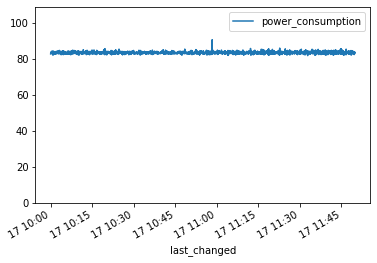

In [60]:
# power consumption when not training
start_date = '2020-06-17'
end_date = '2020-06-17'
start_time = '10:00'
end_time = '11:50'


regular_power_draw = df_new.loc[start_date:end_date].between_time(start_time, end_time)[['power_consumption']]

print(regular_power_draw.describe())
y_max = regular_power_draw['power_consumption'].max() * 1.2

regular_power_draw[(df_new != 0).all(1)].plot(ylim=(0,y_max))

/Users/shivangi/Documents/power_monitor/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


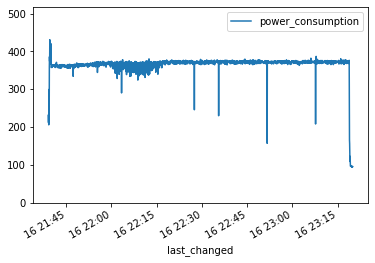

In [76]:
# df_subset = df.loc['2020-06-01':'2020-06-01'].between_time('8:00', '8:38')[['power_consumption']]
# df_subset[(df_subset != 0).all(1)].plot(ylim=(0,df_subset.max()*1.2))

# power consumption during training 2020-06-17 00:18:51.139000 2020-06-16 22:38:46.470000
start_date = '2020-06-16'
end_date = '2020-06-16'
start_time = '21:39'
end_time = '23:20'


subset_df = df_new.loc[start_date:end_date].between_time(start_time, end_time)[['power_consumption']]
y_max = subset_df['power_consumption'].max() * 1.2

subset_df[(df_new != 0).all(1)].plot(ylim=(0,y_max))

In [77]:
adj_subset_df= subset_df['power_consumption'] - regular_power_draw['power_consumption'].mean()
adj_subset_df.describe()

count    2020.000000
mean      281.592667
std        30.554610
min        10.863798
25%       282.824298
50%       286.716798
75%       289.092548
max       347.241798
Name: power_consumption, dtype: float64

edit: the reading is one hour behind.


In [79]:
281 * 5991.57

1683631.17

/Users/shivangi/Documents/power_monitor/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


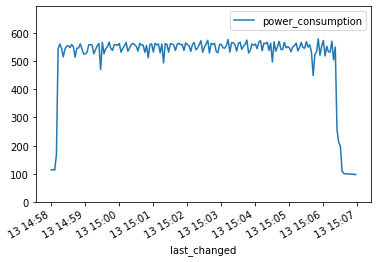

In [81]:
#2020-06-13 15:58:07.779 2020-06-13 16:06:21.295 
# for sst-2 training
start_date = '2020-06-13'
end_date = '2020-06-13'
start_time = '14:58'
end_time = '15:07'


subset_df3 = df_new.loc[start_date:end_date].between_time(start_time, end_time)[['power_consumption']]
y_max = subset_df3['power_consumption'].max() * 1.2

subset_df3[(df_new != 0).all(1)].plot(ylim=(0,y_max))

/Users/shivangi/Documents/power_monitor/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


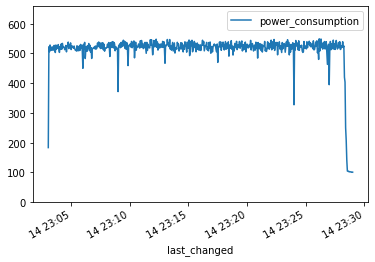

In [83]:
#2020-06-15 00:03:01.213	2020-06-15 00:28:19.418
start_date = '2020-06-14'
end_date = '2020-06-14'
start_time = '23:03'
end_time = '23:29'


subset_df4 = df_new.loc[start_date:end_date].between_time(start_time, end_time)[['power_consumption']]
y_max = subset_df4['power_consumption'].max() * 1.2

subset_df4[(df_new != 0).all(1)].plot(ylim=(0,y_max))

In [24]:
#plt.savefig('power.pdf')

<Figure size 432x288 with 0 Axes>

In [69]:
def plot_power(start_date,end_date,start_time,end_time):
    subset_df4 = df_new.loc[start_date:end_date].between_time(start_time, end_time)[['power_consumption']]
    y_max = subset_df4['power_consumption'].max() * 1.2

    subset_df4[(df_new != 0).all(1)].plot(ylim=(0,y_max))

/Users/shivangi/Documents/power_monitor/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


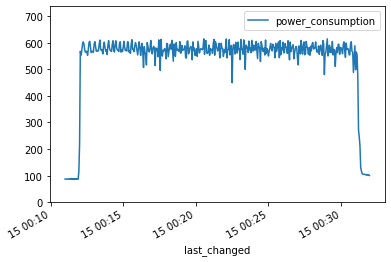

In [85]:
#2020-06-15 01:11:57.344	2020-06-15 01:31:09.314
plot_power('2020-06-15','2020-06-15','00:11','00:32')

/Users/shivangi/Documents/power_monitor/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


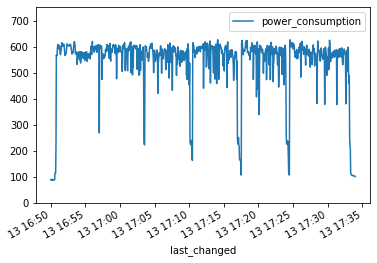

In [87]:
#2020-06-13 17:50:43.918	2020-06-13 18:33:06.280
plot_power('2020-06-13','2020-06-13','16:50','17:34')

/Users/shivangi/Documents/power_monitor/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


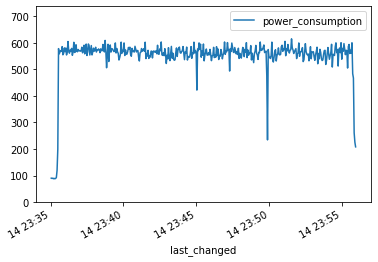

In [89]:
#2020-06-15 00:35:27.709	2020-06-15 00:55:47.985
plot_power('2020-06-14','2020-06-14','23:35','23:56')